# Face Mask Detection using Web-Camera

To detect the mask of a person, we use alexnet as our deep learning model and haar cascade classifier for seeing a face. A custom dataset is used to train the model. And the model achieves the highest accuracy with this custom dataset, which is 100%.

# Importing necessary modules

In [1]:
import os
import pickle
import cv2
import random
from tqdm import tqdm
from tqdm.notebook import tnrange
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Preprocessing 

In [2]:
DATA_DIR = 'E:\All About - AI\MaskedFaceNet'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
VALID_DATA_DIR = os.path.join(DATA_DIR, 'valid')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')

In [3]:
IMG_SIZE = 227
CATEGORIES = []

for i in os.listdir(TRAIN_DATA_DIR):
    CATEGORIES.append(i)
    
print(CATEGORIES)

['without_mask', 'with_mask']


In [4]:
# for c in CATEGORIES:
#     path = os.path.join(TRAIN_DATA_DIR, c)
#     i = 1
#     for k in range(2001, 2995):
#         os.remove(os.path.join(path, str(k)+".png"))
#         os.rename(os.path.join(path, str(k)+".png"), os.path.join(path, str(i)+".png"))
#         i += 1

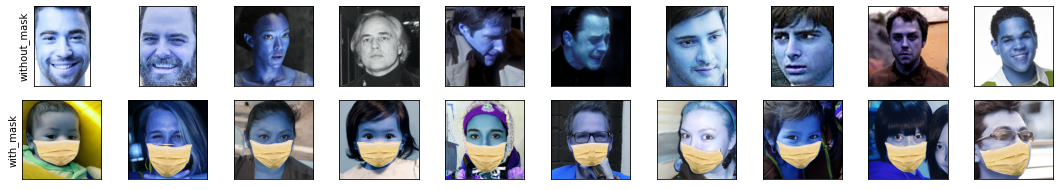

In [5]:
plt.figure(figsize=(15,4))
i=0
for c in CATEGORIES:  
    path = os.path.join(TRAIN_DATA_DIR,c)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))
        plt.subplot(3,10,i+1)
        plt.imshow(img_array)
        if i%10 == 0:
            plt.ylabel(c)
        plt.xticks([])
        plt.yticks([])
        i += 1
        if i%10 == 0:
            break

plt.tight_layout()        
plt.show() 

In [6]:
training_data = []

for c in CATEGORIES:
    path = os.path.join(TRAIN_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) # 0
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   # read the image
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  # resize the image
            training_data.append([img_resized, class_num]) # [ [img, 0], [], [], [], ...., []]
        except WException as e:
            pass
        
print(len(training_data))

100%|██████████████████████████████████████████████████████████████████████████████| 1912/1912 [00:58<00:00, 32.93it/s]

3763


In [7]:
valid_data = []

for c in CATEGORIES:
    path = os.path.join(VALID_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            valid_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(valid_data))

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 35.97it/s]

1000


In [8]:
test_data = []

for c in CATEGORIES:
    path = os.path.join(TEST_DATA_DIR, c) 
    class_num = CATEGORIES.index(c) 
    for img in tqdm(os.listdir(path)):
        try:
            img_array = cv2.imread(os.path.join(path, img))   
            img_resized = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))  
            test_data.append([img_resized, class_num])
        except WException as e:
            pass
        
print(len(test_data))

100%|████████████████████████████████████████████████████████████████████████████████| 149/149 [00:04<00:00, 33.90it/s]

299


In [9]:
random.shuffle(training_data)
random.shuffle(valid_data)
random.shuffle(test_data)

In [10]:
X_train = []
Y_train = []

for img, label in training_data:
    X_train.append(img)
    Y_train.append(label)
    
X_train = np.array(X_train).astype('float32').reshape(-1,227,227,3)
Y_train = np.array(Y_train)

print(f"X_train= {X_train.shape} Y_train= {Y_train.shape}")

X_train= (3763, 227, 227, 3) Y_train= (3763,)


In [11]:
X_valid = []
Y_valid = []

for img, label in valid_data:
    X_valid.append(img)
    Y_valid.append(label)
    
X_valid = np.array(X_valid).astype('float32').reshape(-1,227,227,3)
Y_valid = np.array(Y_valid)

print(f"X_valid= {X_valid.shape} Y_valid= {Y_valid.shape}")

X_valid= (1000, 227, 227, 3) Y_valid= (1000,)


In [12]:
X_test = []
Y_test = []

for features,label in test_data:
    X_test.append(features)
    Y_test.append(label)

X_test = np.array(X_test).astype('float32').reshape(-1, IMG_SIZE, IMG_SIZE, 3)
Y_test = np.array(Y_test)

print(f"X_test= {X_test.shape} Y_test= {Y_test.shape}")

X_test= (299, 227, 227, 3) Y_test= (299,)


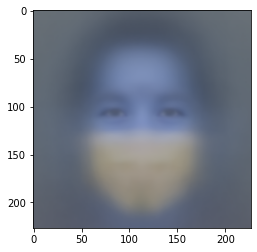

In [13]:
mean_img = np.mean(X_train, axis=0)
plt.imshow(mean_img.astype('uint8'))

In [14]:
X_train_norm, X_valid_norm, X_test_norm = X_train-mean_img, X_valid-mean_img, X_test-mean_img

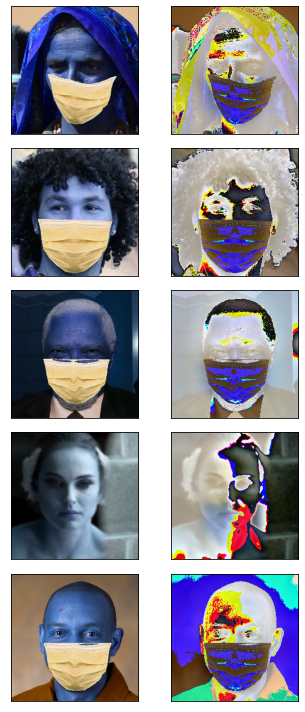

In [15]:
c = 0
plt.figure(figsize=(5,10))
for i in range(5):
    plt.subplot(5,2,c+1)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(5,2,c+2)
    plt.imshow(X_train_norm[i].astype('uint8'))
    plt.xticks([])
    plt.yticks([])

    c += 2
    
plt.tight_layout()
plt.show()

# Building the Model

In [16]:
model = keras.Sequential([
    ## input layer
    keras.Input(shape=X_train.shape[1:]),
    
    
    layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.BatchNormalization(),
    
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='valid'),
    layers.Activation('relu'),
    layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'),
    layers.BatchNormalization(),
    
    layers.Flatten(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),
    
    layers.Dense(units=4096),
    layers.Activation('relu'),
    layers.Dropout(0.5),
    layers.BatchNormalization(),

    layers.Dense(2),
    layers.Activation('softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [17]:
model.compile(
    optimizer='adam', 
    loss= 'sparse_categorical_crossentropy',
    metrics=['loss']
)

In [18]:
h = model.fit(x=X_train_norm, y=Y_train, epochs=5, validation_data=(X_valid_norm, Y_valid), batch_size=32)

Epoch 1/5
118/118 [==============================] - 277s 2s/step - loss: 0.0954 - accuracy: 0.9822 - val_loss: 2.2650e-09 - val_accuracy: 1.0000
Epoch 2/5
118/118 [==============================] - 266s 2s/step - loss: 0.0529 - accuracy: 0.9931 - val_loss: 3.6184e-06 - val_accuracy: 1.0000
Epoch 3/5
118/118 [==============================] - 255s 2s/step - loss: 0.0045 - accuracy: 0.9989 - val_loss: 9.7629e-08 - val_accuracy: 1.0000
Epoch 4/5
118/118 [==============================] - 266s 2s/step - loss: 0.0120 - accuracy: 0.9979 - val_loss: 1.4446e-05 - val_accuracy: 1.0000
Epoch 5/5
118/118 [==============================] - 262s 2s/step - loss: 0.0199 - accuracy: 0.9960 - val_loss: 0.0117 - val_accuracy: 0.9990


In [19]:
predictions = model.predict(X_test)

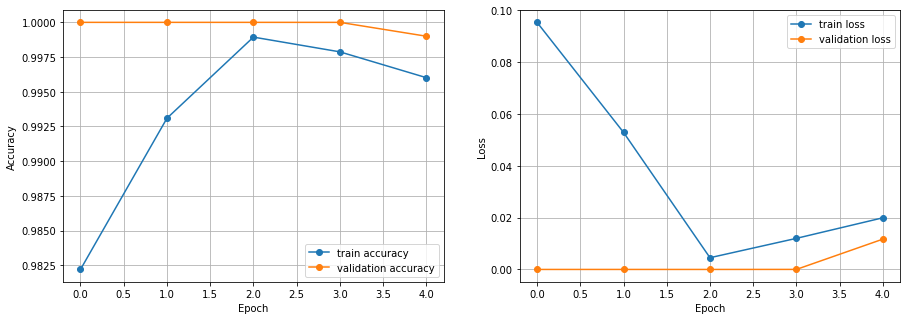

In [20]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.plot(h.history['val_accuracy'], 'o-', label = 'validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.plot(h.history['val_loss'], 'o-', label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

In [21]:
test_loss, test_acc = model.evaluate(X_test_norm, Y_test)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

10/10 [==============================] - 5s 537ms/step - loss: 0.0000e+00 - accuracy: 1.0000

Test Accuracy: 1.0

Test Loss: 0.0


Prediction:  1
Ground Truth:  1
with_mask


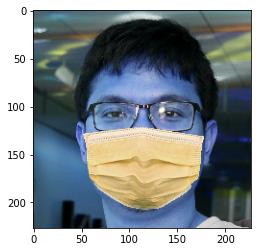

In [43]:
test = 9
p = model.predict(X_test[test].reshape(-1, 227, 227,3))
temp = np.argmax(p)
print("Prediction: ", np.argmax(p))
print("Ground Truth: ", Y_test[test])
plt.imshow(X_test[test].astype('uint8'))
print(CATEGORIES[temp])

# Save & Load Model

In [23]:
model.save('model.h5')

In [24]:
from keras.models import load_model
new = load_model('model.h5')
new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 55, 55, 96)        34944     
                                                                 
 activation (Activation)     (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 27, 27, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 27, 27, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 256)       2973952   
                                                                 
 activation_1 (Activation)   (None, 17, 17, 256)       0

In [48]:
import pickle

with open('mean.pickle', 'wb') as handle:
    pickle.dump(mean_img, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('mean.pickle', 'rb') as handle:
    backup_mean_img = pickle.load(handle)

# Deploying the model with Web Cam Test

In [49]:
import cv2
import numpy as np
# Load the cascade
face_cascade = cv2.CascadeClassifier('E:\\All About - AI\\haar-cascade-files-master\\haarcascade_frontalface_alt2.xml')

# define a video capture object
vid = cv2.VideoCapture(0)

try:
    while(True):
        # Capture the video frame
        # by frame
        ret, frame = vid.read()

        # Convert to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # Detect the faces
        faces = face_cascade.detectMultiScale(gray, 1.1, 2)
        
        
        # Draw the rectangle around each face
        for (x, y, w, h) in faces:
            cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
    
            #Predict
            temp = frame[y:y+h, x:x+w]
            temp = cv2.resize(temp, (227,227))
            pr = new.predict(temp.reshape(-1,227,227, 3) - backup_mean_img)
            
            confidence = pr;
            pr = np.argmax(pr)
#             print(pr)
            confidence = confidence[0][pr]
            
            if(pr == 1):
                cv2.putText(frame, 
                        "With_Mask : " + str(confidence), 
                        (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        .5, 
                        (0, 255, 0), 
                        2, 
                        cv2.LINE_4)
            else:
                cv2.putText(frame, 
                        "Without_Mask : " + str(confidence), 
                        (x, y-10),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        .5, 
                        (0, 0, 255), 
                        2, 
                        cv2.LINE_4)
            
        # Display the resulting frame
        cv2.imshow('frame', frame)
        
        # the 'q' button is set as the
        # quitting button you may use any
        # desired button of your choice
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()
except:
    print("Something went wrong")
    # After the loop release the cap object
    vid.release()
    # Destroy all the windows
    cv2.destroyAllWindows()

